In [ ]:
%pip install labelme tensorflow opencv-python matplotlib albumentations 

# 1. Obtenció i tractament de dades

### 1.1 Ús de la llibreria LabelMe

In [ ]:
!labelme 

###  1.2 Creació de la base de dades

In [1]:
#importació de llibreries necessàries
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import shutil
import math

In [ ]:
#limitació de la memòria GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
imatges = tf.data.Dataset.list_files('imatges\\*.jpg') # introduïm les imatges

In [2]:
def carregar_imatge(imatge): #funció per a carregar imatges
    byte_img = tf.io.read_file(imatge)
    img = tf.image.decode_jpeg(byte_img)
    return img

In [ ]:
imatges = imatges.map(carregar_imatge) #executem la funció 

In [ ]:
imatges.as_numpy_iterator().next() 

In [ ]:
def imatgesDividir(dir_carpeta, n_imatges):
    num_elements = len(os.listdir(os.path.join(dir_carpeta, "imatges")))
    n_train = round(num_elements*0.7) # 70% de les imatges per entrenar
    n_test = round(num_elements*0.15) # 15% de les imatges per provar
    n_val = num_elements - (n_train + n_test) # 15% de les imatges per validar

    llista = []
    for i in range(1, (n_imatges + 1)):
        llista.append(i)

    while len(llista) > n_train:
        if (len(os.listdir(os.path.join(dir_carpeta,"dades","test")))-1)< n_test:
            for i in range(n_test):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta, "imatges", nom ), os.path.join(dir_carpeta, "dades", "test" , "imatges"))
                llista.remove(n)

        if (len(os.listdir(os.path.join(dir_carpeta,"dades","val")))-1) < n_val:
            for i in range(n_val):
                n = random.choice(llista)
                nom = str(str(n) + ".jpg")
                shutil.move(os.path.join(dir_carpeta, "imatges", nom), os.path.join(dir_carpeta,"dades" , "val", "imatges"))
                llista.remove(n)

    for i in llista:
        nom = str(i) + ".jpg"
        shutil.move(os.path.join(dir_carpeta, "imatges", nom), os.path.join(dir_carpeta, "dades","train", "imatges"))

In [ ]:
# Crear la carpeta principal
os.mkdir("dades")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("dades", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("dades", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("dades", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)

imatgesDividir('\practica_tr',300) #divisió de les carpetes i de les imatges

### Partició de les dades

In [ ]:
# mou les els labels a les seves respectives carpetes
def moureLabels(dir_carpeta):
    for carpeta in ['train','test','val']:
        for arxiu in os.listdir(os.path.join(dir_carpeta,'dades', carpeta, 'imatges')): #per cada arxiu en cada carpeta
            n = arxiu.split(".")
            json = str(n[0] + ".json")
            shutil.move(os.path.join(dir_carpeta, "labels", json ), os.path.join(dir_carpeta, "dades", carpeta, "labels"))#canviem

In [ ]:
moureLabels('\practica_tr')

### 1.2.1 Ús de la llibreria Albumentation

In [3]:
import albumentations as alb
import cv2

In [4]:
augmentor = alb.Compose([alb.RandomCrop(width=1024, height=1024),
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.5),
                         alb.RandomGamma(p=0.7), 
                         alb.RGBShift(p=0.5), 
                         alb.VerticalFlip(p=0.7)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [7]:
os.mkdir("aug_dades")

# Crear les subcarpetes dins de la carpeta principal
for subcarpeta in ["train", "test", "val"]:
    path_subcarpeta = os.path.join("aug_dades", subcarpeta)
    os.mkdir(path_subcarpeta)
    path_subsubcarpeta = os.path.join("aug_dades", subcarpeta, "imatges")
    os.mkdir(path_subsubcarpeta)
    path_subsubcarpeta2 = os.path.join("aug_dades", subcarpeta, "labels")
    os.mkdir(path_subsubcarpeta2)


In [8]:
classes_fruita = {"poma": [1,0,0], "pera": [0,1,0] , "mandarina": [0,0,1]}
partitions = ['train', 'test', 'val']

for partition in partitions:
    input_folder = os.path.join('dades', partition, 'imatges')
    output_folder = os.path.join('aug_dades', partition, 'imatges')

    for imatge in os.listdir(input_folder):
        img_path = os.path.join(input_folder, imatge)
        img = cv2.imread(img_path)
        label_path = os.path.join('dades', partition, 'labels', f'{imatge.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            for shape in label['shapes']:
                class_name = shape['label'] 
                class_id = classes_fruita[class_name]
                coords = shape['points']
                coords = [(coords[0][0]/1024), (coords[0][1]/1024), (coords[1][0]/1024), (coords[1][1]/1024)]

                try:
                    for x in range(5):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=[class_name])
                        augmented_img = augmented['image']

                        annotation = {
                            'image': f'{imatge.split(".")[0]}.{x}.jpg',
                            'bbox': augmented['bboxes'],
                            'class': class_id,
                        }
                        output_img_path = os.path.join(output_folder, annotation['image'])
                        cv2.imwrite(output_img_path, augmented_img)

                        output_json_path = os.path.join('aug_dades', partition, 'labels', f'{imatge.split(".")[0]}.{x}.json')
                        with open(output_json_path, 'w') as f:
                            json.dump(annotation, f) 
                except Exception as e:
                    print(e)


Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)
Requested crop size (1024, 1024) is larger than the image size (512, 512)


### Incloure imatges creades amb Albumentations a la Dataset

In [9]:
train_imatges = tf.data.Dataset.list_files('aug_dades\\train\\imatges\\*.jpg',shuffle=False)
train_imatges = train_imatges.map(carregar_imatge)
train_imatges = train_imatges.map(lambda x: tf.image.resize(x, (120,120)))
train_imatges = train_imatges.map(lambda x: x/255)

In [10]:
test_imatges = tf.data.Dataset.list_files('aug_dades\\test\\imatges\\*.jpg', shuffle=False)
test_imatges = test_imatges.map(carregar_imatge)
test_imatges = test_imatges.map(lambda x: tf.image.resize(x, (120,120)))
test_imatges = test_imatges.map(lambda x: x/255)

In [11]:
val_imatges = tf.data.Dataset.list_files('aug_dades\\val\\imatges\\*.jpg', shuffle=False)
val_imatges = val_imatges.map(carregar_imatge)
val_imatges = val_imatges.map(lambda x: tf.image.resize(x, (120,120)))
val_imatges = val_imatges.map(lambda x: x/255)

In [ ]:
train_imatges.as_numpy_iterator().next()

### 2.5 Carregar labels

In [12]:
def carregar_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [14]:
train_labels = tf.data.Dataset.list_files('aug_dades\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [13]:
test_labels = tf.data.Dataset.list_files('aug_dades\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels = tf.data.Dataset.list_files('aug_dades\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(carregar_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

### Combinar etiquetes i imatges

In [16]:
num_elements={}
for carpeta in ['train','test','val']:
    x = len(os.listdir(os.path.join('aug_dades', carpeta, 'imatges')))
    num_elements.update({carpeta : round(x * 1.5)})

In [17]:
train = tf.data.Dataset.zip((train_imatges, train_labels))
train = train.shuffle(num_elements['train'])
train = train.batch(5)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_imatges, test_labels))
test = test.shuffle(num_elements['test'])
test = test.batch(5)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_imatges, val_labels))
val = val.shuffle(num_elements['val'])
val = val.batch(5)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()

# 2. Preparació de la intel·ligència artificial

### 2.1 Descarregar i carregar el model VGG16

In [20]:
import tensorflow.keras.models
import tensorflow.keras.layers
import tensorflow.keras.applications

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(include_top=False) 
#Marca que les ultimes capes de la xarxa no les utilitzarem perquè afegirem les nostres pròpies

In [22]:

'''
La funció crea i retorna un model de xarxa neuronal convolucional per a la detecció dels objectes. 
El model té dues parts: una per a determinar si una imatge conté algun objecte i una altra per a localitzar l'obkecte (poma, pera o mandarina) a l'imatge. 
Al utilitzar VGG16, com que esta pre-entrenada, les característiques del input
i les classifica en dues branques que son les dues parts mencionades abans de manera automàtica. 
'''
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    #Model de classificació
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) #relu == funció que determina la classe; 
    class2 = Dense(3, activation='sigmoid')(class1) # sigmoid == funció que determina la presició de la classe

    # sigmoid = f(x) = 1/(1+e^-x)
    
    #Model de localització de coordenades
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    detector = Model(inputs=input_layer, outputs=[class2, regress2])
    return detector

In [23]:
detector = build_model()

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes, coords = detector.predict(X)


In [ ]:
classes,coords


### 2.2 Funcions de pèrdua i optimitzadors
Els optimitzadors són algorismes que s’utilitzen per ajustar els pesos d’una xarxa neuronal durant l’entrenament. Els optimitzadors són responsables de minimitzar la funció de pèrdua de la xarxa neuronal.

In [24]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001) #li introduïm el decay que hem calculat a l'optimitzador

'''
En el context de les xarxes neuronals, un optimitzador és un algorisme
que ajuda a ajustar els paràmetres de la xarxa per aconseguir una millor precisió.
L'optimitzador Adam és un exemple d'això i ajuda a l'optimitzador a convergir més ràpidament
i amb més precisió.
'''

"\nEn el context de les xarxes neuronals, un optimitzador és un algorisme\nque ajuda a ajustar els paràmetres de la xarxa per aconseguir una millor precisió.\nL'optimitzador Adam és un exemple d'això i ajuda a l'optimitzador a convergir més ràpidament\ni amb més precisió.\n"

### Creació de 'Localitzation Loss' i 'Classification Loss'

La funció té dos components: la pèrdua de localització i la pèrdua de classificació.
La pèrdua de localització mesura la diferència entre les coordenades dels quadres delimitadors 
predits i les coordenades dels quadres delimitadors reals. La pèrdua de classificació mesura la
diferència entre les probabilitats de classe predites i les probabilitats de classe reals. 
En aquesta funció, només es calcula la pèrdua de localització.

La funció té com a entrada dos tensors: y_true i yhat. 
y_true conté les coordenades dels quadres delimitadors reals i
les probabilitats de classe reals per a cada objecte en la imatge d’entrada.
yhat conté les coordenades dels quadres delimitadors predits i les
probabilitats de classe predites per a cada objecte en la imatge d’entrada.

La funció calcula la pèrdua de localització sumant el quadrat de la diferència
entre les coordenades dels quadres delimitadors reals i les coordenades dels quadres
delimitadors predits. A continuació, calcula la diferència entre l’amplada i l’alçada
dels quadres delimitadors reals i els quadres delimitadors predits i suma els quadrats
d’aquestes diferències. Finalment, retorna la suma de les dues pèrdues.

In [25]:
def localization_loss(y_true, yhat):#primer valor: coordenades reals, segon valor: coordenades previstes     
    y_true = tf.reshape(y_true, (5, 4))
    
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #diferència dels dos primers valors de cada fila de la matriu
                  
    h_true = y_true[:,3] - y_true[:,1] #quarta columna d'una matriu - segona columna
    w_true = y_true[:,2] - y_true[:,0] #tercera columna - primera

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    '''
    delta_size = suma dels quadrats de les diferències entre les dimensions originals 
    i les dimensions reconstruïdes de l'imatge.
    '''
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [26]:
classloss = tf.keras.losses.CategoricalCrossentropy() #model que fa una classificació binaria 
regressloss = localization_loss #model que acabem de crear

In [ ]:
regressloss(y[1], coords)

In [ ]:
y_reshaped = tf.reshape(y[0], (5, 3))
classloss(y_reshaped, classes)

In [ ]:
localization_loss(y[1], coords)

# 3. Entrenament de la intel·ligència artificial

### 3.1 Creació del propi model 

In [27]:
import keras
from tensorflow.keras.utils import serialize_keras_object

In [28]:
# Clear any previously registered custom objects to avoid conflicts
tf.keras.utils.get_custom_objects().clear()

# Register custom objects within the "MyLayers" package
@tf.keras.utils.register_keras_serializable(package="MyLayers")
class Detector(Model):
    def __init__(self, fruita, **kwargs):
        super().__init__(**kwargs)
        self.base_model = fruita

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.base_model(X, training=True)
            batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

        grad = tape.gradient(total_loss, self.base_model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.base_model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.base_model(X, training=False)

        batch_classloss = self.closs(tf.reshape(y[0], (5, 3)), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.base_model(X, **kwargs)
    
    def get_config(self):
        # Get the base configuration
        base_config = super().get_config()
        
        # Serialize the "fruita" model and store it in the configuration
        fruita_config = serialize_keras_object(self.base_model)
        
        # Construct the complete configuration dictionary
        config = {
            "fruita": fruita_config,
        }
        
        # Merge the base configuration and the custom configuration
        return {**base_config, **config}



In [29]:
detector.build(input_shape=(5, 120, 120, 3))
model = Detector(detector)

El 'mode.compile' configura el model per utilitzar l'optimitzador especificat per minimitzar la combinació de les funcions de pèrdua de classificació i regressió durant el procés d'entrenament

In [32]:
model.compile(opt, classloss, regressloss)

### 3.2 Entrenament


In [ ]:
test_data = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(test_data[0])

In [33]:
logdir='logs' #Crea un directori on es guardarà la informació del Tensorboard 

TensorBoard és una eina de visualització interactiva que s'utilitza en l'entrenament de models de xarxes neuronals per poder entendre millor el comportament del model durant l'entrenament i ajustar els paràmetres de manera més efectiva. 


In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #crea un callback per registrar la informació del model 

In [35]:
hist = model.fit(train, epochs=4, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/4
207/207 [==============================] - 433s 2s/step - total_loss: 0.0808 - class_loss: 0.0473 - regress_loss: 0.0572 - val_total_loss: 0.0708 - val_class_loss: 0.0026 - val_regress_loss: 0.0695
Epoch 2/4
207/207 [==============================] - 421s 2s/step - total_loss: 0.0299 - class_loss: 0.0024 - regress_loss: 0.0287 - val_total_loss: 0.0174 - val_class_loss: 0.0014 - val_regress_loss: 0.0167
Epoch 3/4
207/207 [==============================] - 442s 2s/step - total_loss: 0.0161 - class_loss: 5.7700e-04 - regress_loss: 0.0158 - val_total_loss: 0.0916 - val_class_loss: 0.0045 - val_regress_loss: 0.0893
Epoch 4/4
207/207 [==============================] - 453s 2s/step - total_loss: 0.0114 - class_loss: 4.3442e-04 - regress_loss: 0.0111 - val_total_loss: 0.0518 - val_class_loss: 4.2251e-04 - val_regress_loss: 0.0516


Aquesta última línia es passa tota la informació de train (osigui crida a tota la funció d'entrenament) per 10 iteracions (epochs) i registra les dades d'entrenament i validació durant l'entrenament a partir del callback de TensorBoard, llavors "hist" conté tota la info sobre les losses (pèrdues) i l'exactitud del model durant l'entrenament

### 3.3 Anàlisi del rendiment de l'entrenament

In [36]:
hist.history #per veure totes les pèrdues (losses)

{'total_loss': [0.0891406312584877,
  0.008712665177881718,
  0.01738879084587097,
  0.010947146452963352],
 'class_loss': [0.0904085636138916,
  0.0006674163741990924,
  0.0013051439309492707,
  0.0007591571775265038],
 'regress_loss': [0.0439363494515419,
  0.008378957398235798,
  0.016736218705773354,
  0.010567568242549896],
 'val_total_loss': [0.07082165777683258,
  0.017379406839609146,
  0.09155301749706268,
  0.05183848738670349],
 'val_class_loss': [0.0025693748611956835,
  0.0014058046508580446,
  0.004532101564109325,
  0.00042250886326655746],
 'val_regress_loss': [0.0695369690656662,
  0.01667650416493416,
  0.08928696811199188,
  0.05162723362445831]}

El següent fragment mostra totes les losses de manera gràfica, en teoria tant les pèrdues i les pèrdues validades com les de classificació de localització i les totals haurien de ser valors molt semblants per a ser més exactes, en cas que no ho son deu haver-hi algun problema amb alguna anotation i no l'haurà processat bé (tampoc és un problema greu)

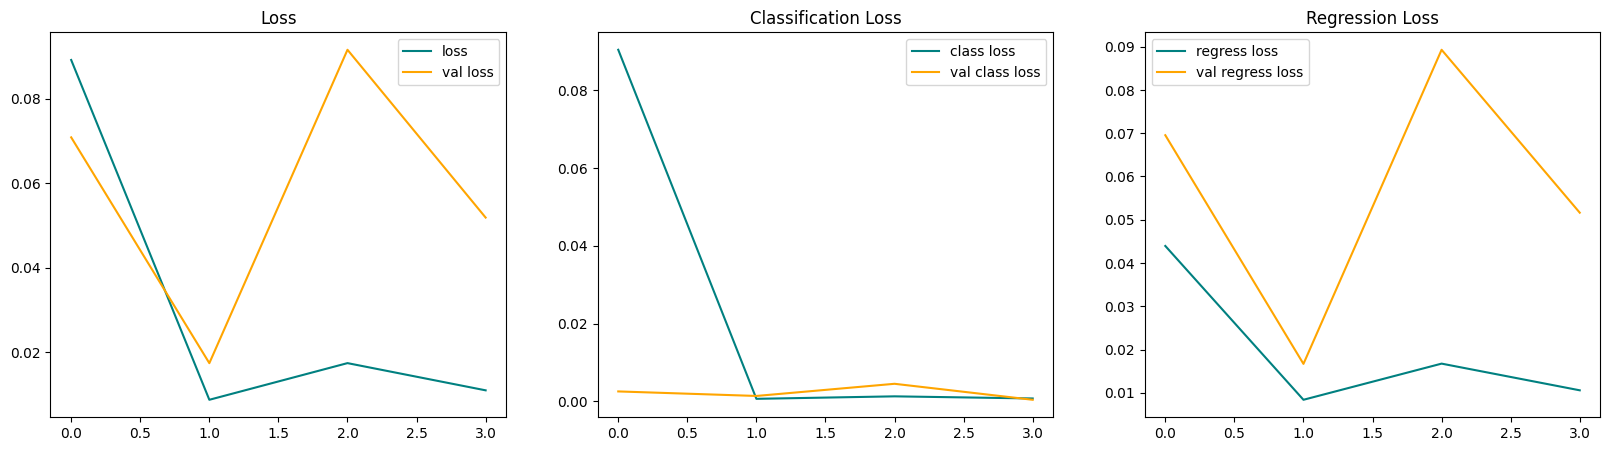

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [38]:
from keras.models import load_model

In [39]:
model.save_weights('detector_fruites_weights.h5')

### PROVA DEL MODEL 

In [40]:
model.build(input_shape=(5, 120, 120, 3))

In [41]:
model.load_weights('detector_fruites_weights.h5')

In [50]:
test_data = test.as_numpy_iterator()

In [51]:
test_sample = test_data.next()

In [52]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 1s 505ms/step


In [ ]:
print(yhat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


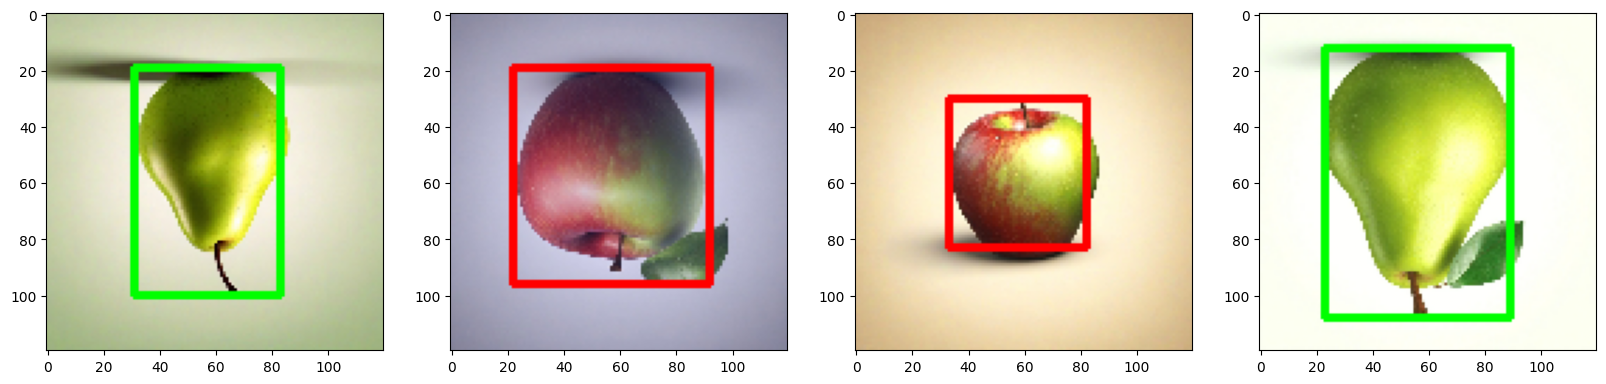

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx][0] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    elif yhat[0][idx][1] > 0.9:
            cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (0,255,0), 2)

    elif yhat[0][idx][2] > 0.9:
         cv2.rectangle(sample_image, 
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,140,0), 2)
    
    ax[idx].imshow(sample_image)